<a href="https://colab.research.google.com/github/kolmar7/rdf/blob/main/RDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radial distribution function

Maria Kolonsky 2025

v.0.2.2

In [33]:

from urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET



## Parse XML datafile for $(x, y)$ points

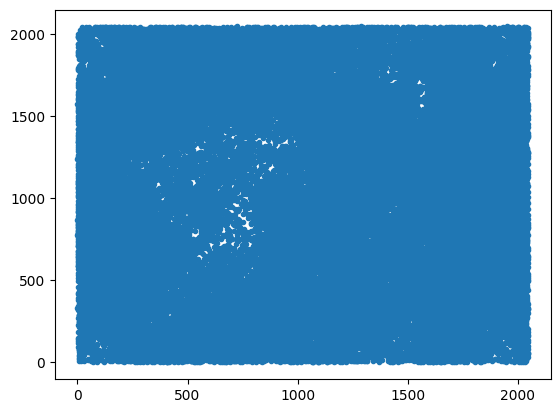

In [35]:
#url = 'https://raw.githubusercontent.com/kolmar7/rdf/refs/heads/main/HaCaT%40pla-gel-CPNW%40PMMA(11x11%2Cx20)_2022-05-30_CellCounter_tile_x001_y002%20(1).xml'
url = 'https://raw.githubusercontent.com/kolmar7/rdf/refs/heads/main/CellCounter_xml.xml'
#парсинг XML
def parsing_xml(xml_path: str, marker_type: int = 1):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    xc, yc = [], []
    for mtype in root.findall(".//Marker_Type"):
        t = mtype.findtext("Type")
        if not t or int(t.strip()) != marker_type:
            continue
        for m in mtype.findall(".//Marker"):
            x = m.findtext("MarkerX")
            y = m.findtext("MarkerY")
            if x and y:
                xc.append(int(x)); yc.append(int(y))
    return np.asarray(xc, dtype=np.int64), np.asarray(yc, dtype=np.int64)


#запуск
resp = urlopen(url, timeout=30)
X, Y = parsing_xml(resp, marker_type=1)

W = int(X.max()) + 1
H = int(Y.max()) + 1

# total square
S = W * H

N =  X.size




plt.scatter(X, Y, marker='.')

## Using module `numpy` to calculate number of area of intersection of a ring and rectangle

In [36]:
def calculate_circle_area(i, j, r):
    """
    Количество пикселей (целочисленных координат) внутри круга
    (yy - i)^2 + (xx - j)^2 <= r^2 с учётом границ изображения H×W.
    i — индекс строки (y), j — индекс столбца (x). 0-based.
    """

    # вертикальные границы круга, обрезанные окном
    y0 = max(0, i - r)
    y1 = min(H - 1, i + r)
    if y0 > y1:
        return 0

    # расстояния по вертикали от центра до каждой строки в пределах круга
    dy = np.arange(y0, y1 + 1, dtype=np.int64) - i
    # горизонтальный полуразброс (целый) для каждой строки
    # (сколько колонок вправо/влево от j попадает в круг)
    xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)

    # для каждой строки находим допустимый интервал колонок в окне [0, W-1]
    left  = np.maximum(0, j - xrad)
    right = np.minimum(W - 1, j + xrad)

    # длина интервала по колонкам (если right<left, длина 0)
    counts = np.maximum(0, right - left + 1)

    return int(counts.sum())

def calculate_ring_area(i, j, r, dr):
  return calculate_circle_area(i, j, r+dr) - calculate_circle_area(i, j, r)

i, j = 100, 100
r, dr = 200, 30
%timeit calculate_ring_area(i, j, r, dr)

51.7 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Using module `numpy` to calculate number of points inside the ring

In [37]:
def count_points(cx, cy, r, deltar):
  distance2 = (X - cx)*(X - cx) + (Y - cy)*(Y - cy)
  r2 = r*r
  rdr2 = (r + deltar) * (r + deltar)
  mask = (distance2 >= r2) & (distance2 <= rdr2)
  count = np.count_nonzero(mask)
  return count

# пример
%timeit count_points(100, 100, 2000, 30)


293 µs ± 8.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Find density as number of points to square of intersection

In [38]:
def density(cx, cy, r, deltar):
  count  = count_points(cx, cy, r, deltar)
  relative_count = count / N
  square = calculate_ring_area(cx, cy, r, deltar)
  relative_square = square / S
  if square == 0:
    rho = 0
  else:
    rho = count / N  * S / square
  return rho

#density = np.vectorize(density)

# пример
%timeit density(cx=100, cy=100, r=200, deltar=30)

361 µs ± 7.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Sweep for all possible radius averaged density




/tmp/ipython-input-2240673710.py:18: RuntimeWarning: invalid value encountered in sqrt
  xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)
/tmp/ipython-input-2240673710.py:18: RuntimeWarning: invalid value encountered in cast
  xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)


CPU times: user 3min 24s, sys: 157 ms, total: 3min 24s
Wall time: 3min 26s


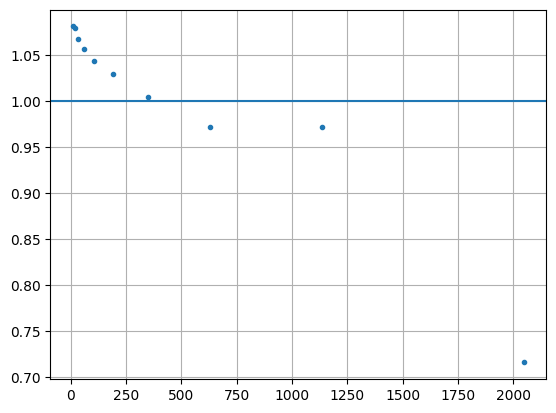

In [43]:
dr = 30
r_max = min(W, H)
r_min = 10

# geometric (logarythmic) spacing makes more steps at near distances and less steps on far distances.
R = np.geomspace(r_min, r_max, num=10)


%time g = [np.mean([density(X[i], Y[i], r, dr) for i in range(N)]) for r in R]


plt.plot(R, g,'.')
plt.axhline(1)
#plt.xlim(0, 1400)
plt.grid()

### The same for uniform distribution

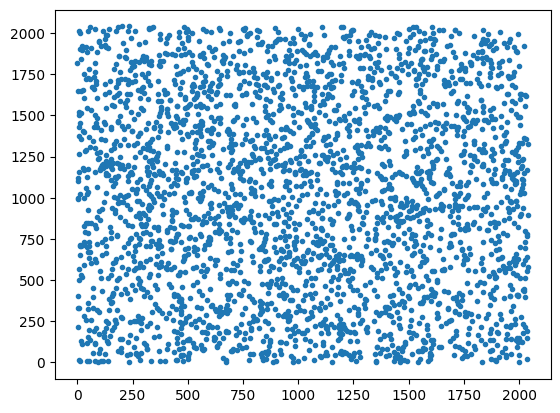

In [ ]:
rng = np.random.default_rng(seed=123)
Xu = rng.uniform(0, W, size=N)
Yu = rng.uniform(0, H, size=N)
plt.scatter(Xu, Yu, marker='.')

In [ ]:
%time gu = [np.mean([density(Xu[i], Yu[i], r, deltar) for i in range(N)]) for r in R]


/tmp/ipython-input-2240673710.py:18: RuntimeWarning: invalid value encountered in sqrt
  xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)
/tmp/ipython-input-2240673710.py:18: RuntimeWarning: invalid value encountered in cast
  xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)


CPU times: user 23.7 s, sys: 15 ms, total: 23.7 s
Wall time: 23.9 s


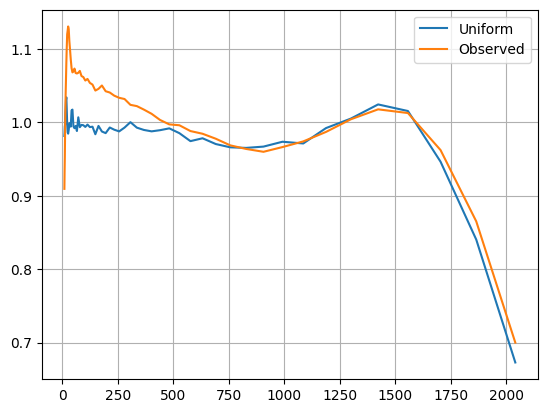

In [ ]:
plt.plot(R, gu, label='Uniform')
plt.plot(R, g, label='Observed')
plt.legend()
#plt.xlim(0, 1400)
plt.grid()

## test for a point in the center with growing radius

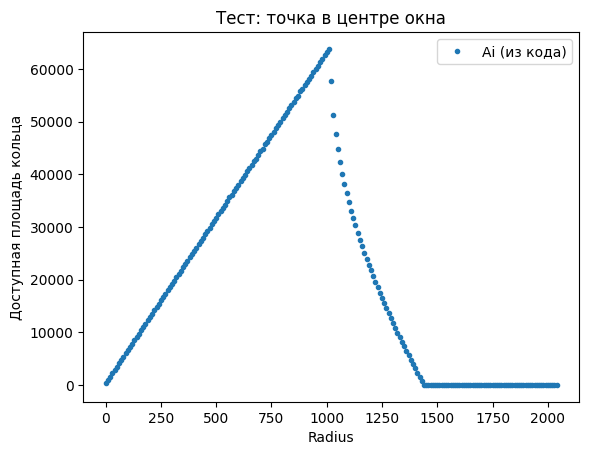

In [ ]:
deltar = 10
R = np.arange(0, W, deltar)

xc, yc = W /2, H / 2

Ai = [calculate_ring_area(xc, yc, r, deltar) for r in R]


# график
plt.plot(R, Ai, '.', lw=2, label="Ai (из кода)")
#plt.plot(R, Ai_theory, 'r--', lw=2, label="Ai (аналитика)")
plt.xlabel("Radius")
plt.ylabel("Доступная площадь кольца")
plt.title("Тест: точка в центре окна")
plt.legend()
plt.show()